Первые 5 строк набора данных:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Количество пропусков (значений 0) в каждом признаке:
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11

Проверка замены пропусков (значений 0):
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0

Размер тренировочного набора: (614, 8)
Размер

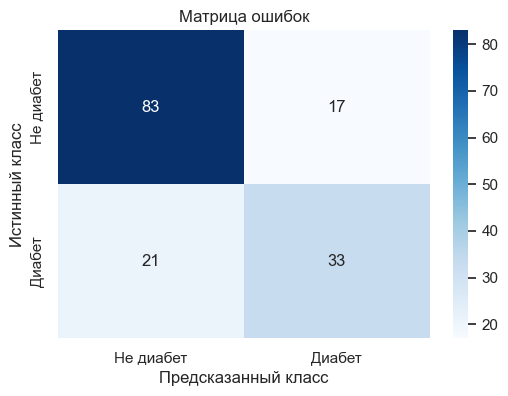


Точность модели KNN: 0.7532
Коэффициент силуэта: 0.1817


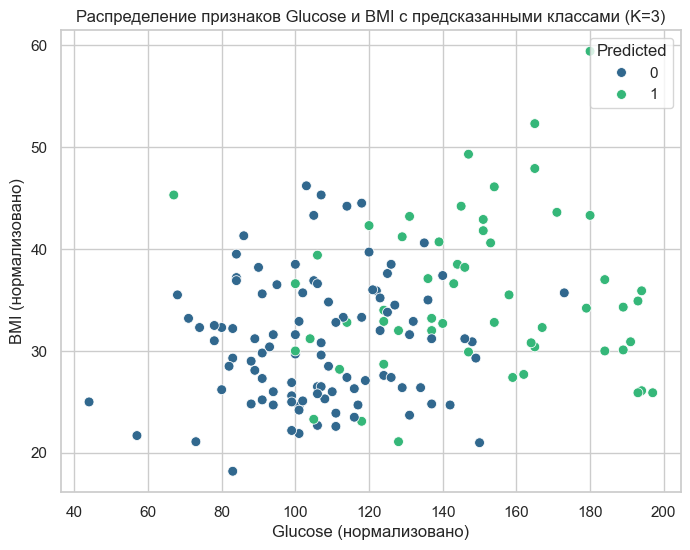

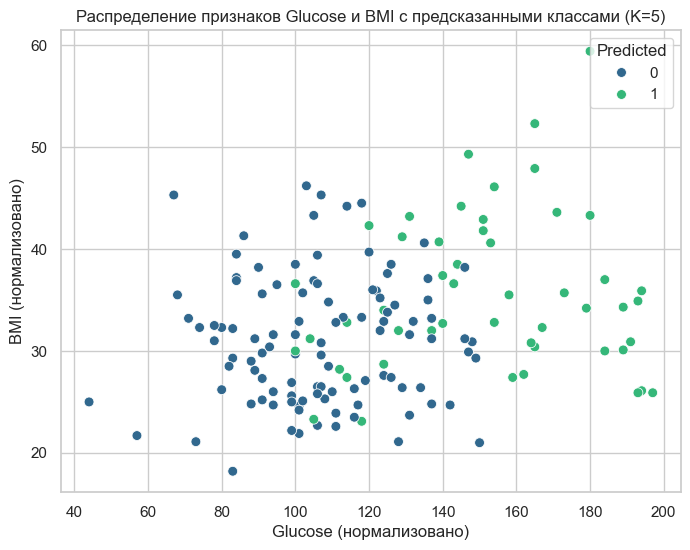

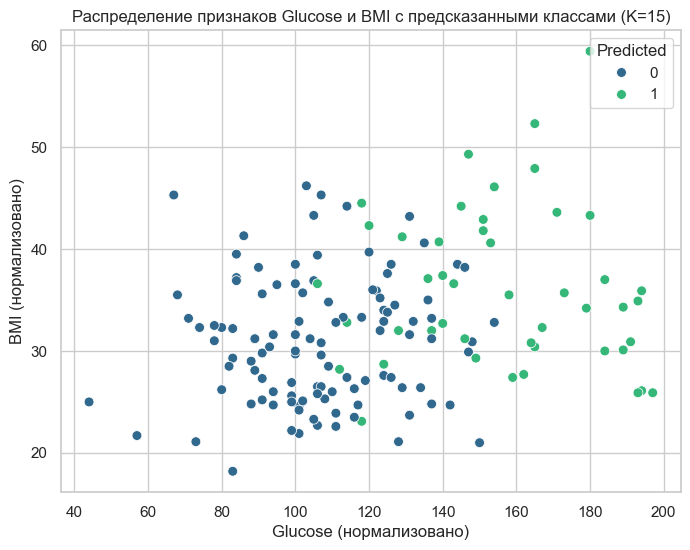

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Установка стиля графиков
sns.set(style="whitegrid")

# Этап 0. Предобработка данных

# Шаг 1. Загрузка данных из CSV файла
data = pd.read_csv('diabetes.csv')
print("Первые 5 строк набора данных:")
print(data.head())

# Шаг 2. Обработка пропусков данных
features_with_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("\nКоличество пропусков (значений 0) в каждом признаке:")
for feature in features_with_missing:
    missing = (data[feature] == 0).sum()
    print(f'{feature}: {missing}')

# Замена пропусков на медиану
for feature in features_with_missing:
    median = data[data[feature] != 0][feature].median()
    data[feature] = data[feature].replace(0, median)

print("\nПроверка замены пропусков (значений 0):")
for feature in features_with_missing:
    missing = (data[feature] == 0).sum()
    print(f'{feature}: {missing}')

# Шаг 3. Разделение данных на тренировочный и тестовый наборы
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\nРазмер тренировочного набора: {X_train.shape}')
print(f'Размер тестового набора: {X_test.shape}')

# Этап 1. Нормализация данных

# Инициализация скалера
scaler = StandardScaler()

# Обучение скалера на тренировочных данных и трансформация
X_train_scaled = scaler.fit_transform(X_train)

# Трансформация тестовых данных
X_test_scaled = scaler.transform(X_test)

# Преобразование обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


# Этап 2. Реализация алгоритма K-ближайших соседей (KNN)

# Инициализация модели KNN с K=5
knn = KNeighborsClassifier(n_neighbors=5)

# Обучение модели на тренировочных данных
knn.fit(X_train_scaled, y_train)
print("Модель KNN обучена на тренировочных данных.")

# Предсказание классов для тестового набора
y_pred = knn.predict(X_test_scaled)

# Добавление предсказаний в DataFrame тестовой выборки
test_results = X_test.copy()
test_results['Actual'] = y_test
test_results['Predicted'] = y_pred

# Просмотр первых нескольких строк результатов
print("\nПервые 5 строк результатов предсказаний:")
print(test_results.head())


# Визуализация матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не диабет', 'Диабет'], 
            yticklabels=['Не диабет', 'Диабет'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

# Вычисление точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'\nТочность модели KNN: {accuracy:.4f}')

# Вычисление коэффициента силуэта
sil_score = silhouette_score(X_test_scaled, y_pred)
print(f'Коэффициент силуэта: {sil_score:.4f}')

# Этап 4. Анализ влияния количества соседей K на работу алгоритма

# Шаг 1. Обучение моделей KNN с разными значениями K и оценка их точности
from sklearn.metrics import accuracy_score

# Диапазон значений K для анализа
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train_scaled, y_train)
    y_pred_k = knn_k.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Шаг 2. Визуализация влияния K на распределение предсказанных классов
selected_k = [3, 5, 15]

for k in selected_k:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train_scaled, y_train)
    y_pred_k = knn_k.predict(X_test_scaled)
    test_results_k = X_test.copy()
    test_results_k['Predicted'] = y_pred_k
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='Glucose', y='BMI', hue='Predicted', palette='viridis', data=test_results_k, s=50)
    plt.title(f'Распределение признаков Glucose и BMI с предсказанными классами (K={k})')
    plt.xlabel('Glucose (нормализовано)')
    plt.ylabel('BMI (нормализовано)')
    plt.legend(title='Predicted')
    plt.show()
